# House Prices

This project is to explore the house features (independent variables) of the data set `train` taken from [Kaggle](https://www.kaggle.com) and build a model using the $SalePrice$ (dependent variable) given in the same data set. The model will then be used to predict the $SalePrice$ of the houses given in the `test` data set and submitted to Kaggle who have the actual
$SalePrice$ of these houses.

## Required Python Modules
1. `numpy`
1. `pandas`
1. `matplotlib`
1. `seaborn`
1. `scipy`
1. `sklearn`

## Import the data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold
import warnings

HousesSold1 = pd.read_csv('data/train.csv', index_col = 'Id')
HousesSold1['data'] = 'train'
HousesSold2 = pd.read_csv('data/test.csv', index_col = 'Id')
HousesSold2['data'] = 'test'
HousesSold = HousesSold1.append(HousesSold2)
print(HousesSold.shape)
print(list(HousesSold.columns))

(2919, 81)
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SalePrice', 'SaleType', 'ScreenPorch', 'St

There are 81 variables in total in this data set and a total of 1460 observations.
## Missing values

It is important that we remove the variables with the significant number of missing values.

In [2]:
allMissing = HousesSold[HousesSold['data']=='train'].isnull().sum().sort_values(ascending=False)
percentage = (HousesSold[HousesSold['data']=='train'].isnull().sum()/HousesSold[HousesSold['data']=='train'].isnull().count()).sort_values(ascending=False)
missingData = pd.concat([allMissing, percentage*100], axis=1, keys=['TotalMissing', 'Percentage'])
missingData.head(20)

,TotalMissing,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


It is not a bad idea to drop the variables $PoolQC$, $MiscFeature$, $Alley$, $Fence$, $FireplaceQu$, and $LotFrontage$ that have 17% or more missing observations. We will think of dealing with the missing values in the remaining variables as we need to deal with them. We would like to add a new variable $HouseAge$ as done below.

In [3]:
HousesSold.drop(labels = ['PoolQC' , 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
                , axis = 1, inplace = True)
HousesSold['HouseAge'] = HousesSold['YrSold'] - HousesSold['YearBuilt']

### Variable types
We notice that the variable $MSSubClass$ is indeed a _categorical_ variable but has been import as an _integer_ column in `pandas`. We can fix that with

In [4]:
HousesSold['MSSubClass'] = HousesSold['MSSubClass'].apply(str)

## Correlations

Variables that are numeric and are strongly correlated with $SalePrice$ variable can be spotted from the heat map of their correlations with each other.

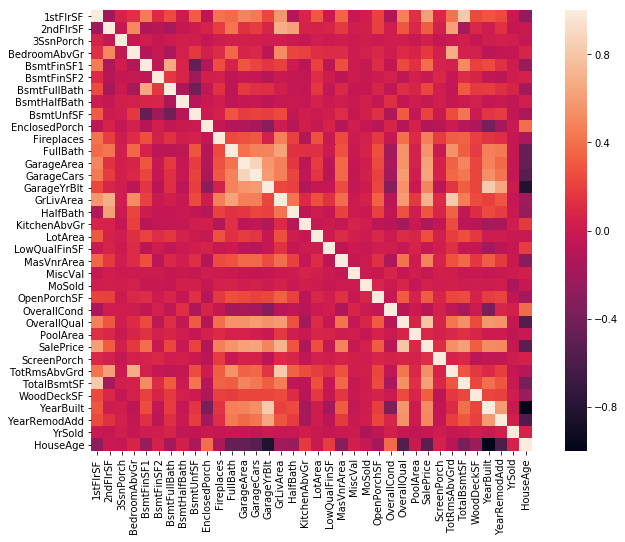

In [5]:
corrmat = HousesSold[HousesSold['data']=='train'].corr()
f2=plt.subplots(1, figsize=(12, 9))

sb.heatmap(corrmat, vmax=1.0, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2)
plt.show()

We can pick the better correlated variables with the $SalePrice$ from the list of all numeric variables as follows

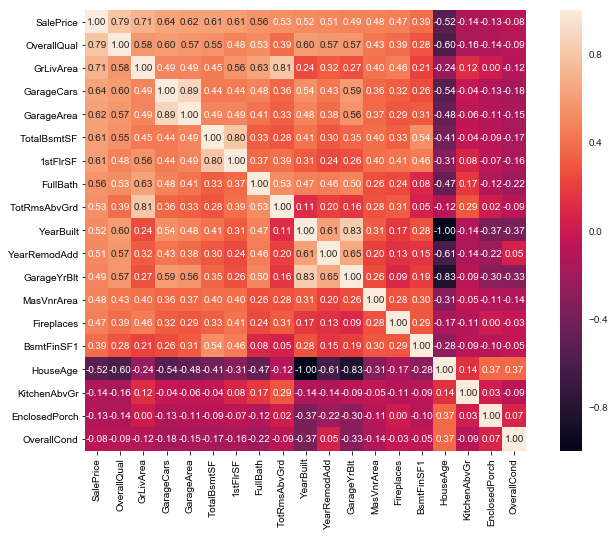

In [6]:
k_pos = 15
k_neg = 4
cols_pos = list(corrmat.nlargest(k_pos, 'SalePrice')['SalePrice'].index)
cols_neg = list(corrmat.nsmallest(k_neg, 'SalePrice')['SalePrice'].index)
cm = HousesSold[cols_pos + cols_neg].corr()
f3=plt.subplots(1, figsize=(12, 9))
sb.set(font_scale=1)
sb.heatmap(cm, cbar=True, annot = True, square=True, fmt='.2f'
           , annot_kws={'size': 10}, yticklabels=cols_pos + cols_neg, xticklabels=cols_pos + cols_neg)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.subplots_adjust(bottom=0.2)
plt.show()

Thus, we observe that the variable $SalePrice$ has some correlation with the following variables:

 1. $OverallQual$
 1. $GrLivArea$
 1. $GarageCars$
 1. $GarageArea$
 1. $TotalBsmtSF$
 1. $1stFlrSF$
 1. $FullBath$
 1. $TotRmsAbvGrd$
 1. $YearBuilt$
 1. $YearRemodAdd$
 1. $GarageYrBlt$
 1. $MasVnrArea$
 1. $Fireplaces$
 1. $BsmtFinSF1$
 1. $KitchenAbvGr$
 1. $EnclosedPorch$
 1. $OverallCond$

It is obvious that the variables $GarageArea$ and $GarageCars$ are correlated with each other. Similarly, $GrLivArea$ and $TotRmsAbvGrd$ are strongly correlated and so are the variables $GarageYrBlt$, $HouseAge$ and $YearBuilt$. The variable $YearBuilt$ is very strongly inverse correlated with the $HouseAge$ variable. We will drop one of these variables; the variable $YearBuilt$ seems a better candidate to be dropped.

In [7]:
better_corr_num = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'
                        , 'FullBath', 'TotRmsAbvGrd', 'HouseAge', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea'
                        , 'Fireplaces', 'BsmtFinSF1', 'KitchenAbvGr', 'EnclosedPorch', 'OverallCond']
HousesSold = HousesSold[better_corr_num + HousesSold.select_dtypes(exclude=[np.number]).columns.tolist() + ['SalePrice']]

We notice that the variables $GarageYrBlt$ and $MasVnrArea$ have some missing values and these variables have some correlation with the reponse variable $SalePrice$. It seems sensible to replace missing values of $GarageYrBlt$ with zero as these are the houses that have no garage. It will, therefore, be good to remove the impact of year variable when the garage was built. Similarly, the houses that have missing $MasVnrArea$ are the ones that have no masonary veneer and it is okay to fill zeros for these. Also we are good to remove the other columns that have missing values except $Electrical$.

In [8]:
HousesSold['GarageYrBlt'].fillna(0, inplace = True)
HousesSold['MasVnrArea'].fillna(0, inplace = True)
HousesSold.drop(labels = ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual', 'BsmtFinType2'
                          , 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType']
                , axis = 1, inplace = True)

### Exploratory data analysis
#### Numerical variables

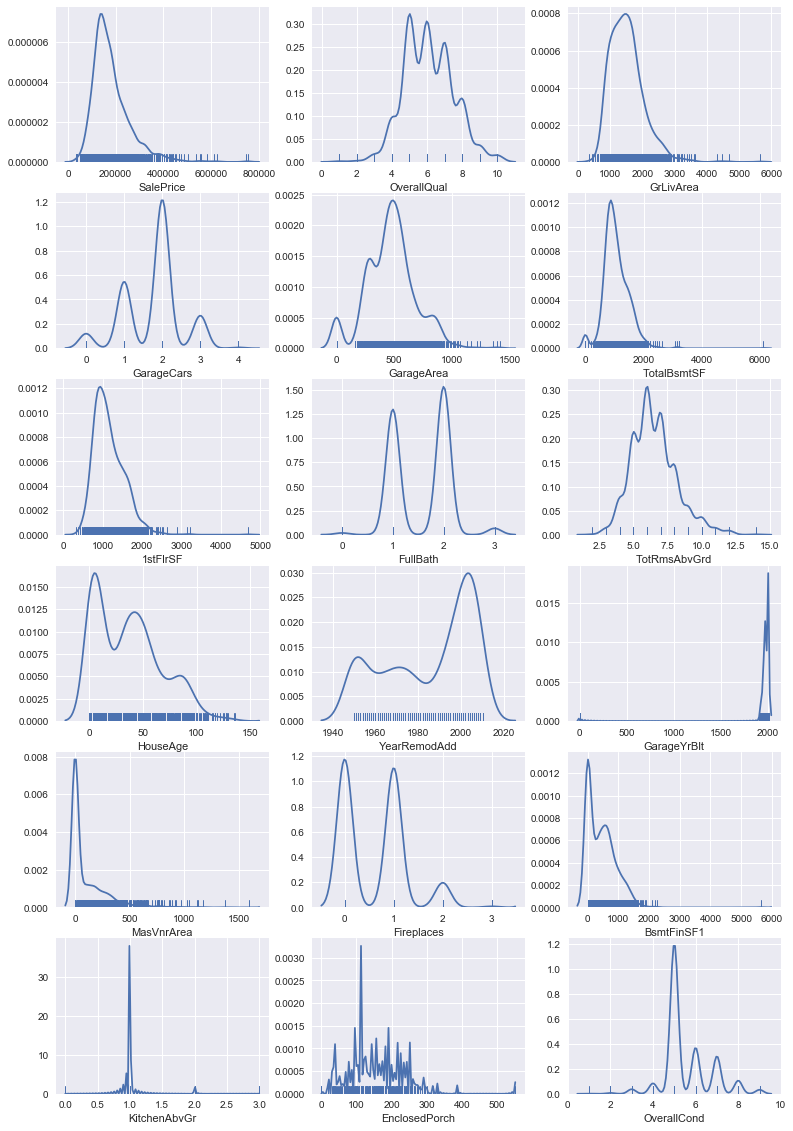

In [9]:
f, axes = plt.subplots(figsize=(13,20), ncols=3, nrows=6)
for i, col in enumerate(['SalePrice']+better_corr_num):
    sb.distplot(HousesSold[HousesSold['data'] == 'train'][[col]], hist=False, rug=True, ax = axes[divmod(i, 3)[0]][i % 3])
    axes[divmod(i, 3)[0]][i % 3].set_xlabel(col)
plt.show()

The response variable $SalePrice$ is right-skewed and can perhaps be transformed to have approximately normal shape with a _log_ transformation. Similarly, the variables $GrLivArea$, $HouseAge$ and $1stFlrSF$ can be transformed with a _log_ transformation to have an approximately normal shape.

The variables $GarageArea$, $TotalBsmtSF$, $MasVnrArea$, and $BsmtFinSF1$ are also right-skewed but a _log_ transformation can not be applied on these for some zero values. We will apply _fourth root_ on these to make them approximately normal, except that there will be a peak at zeros. We plot the above figure after these transformations.

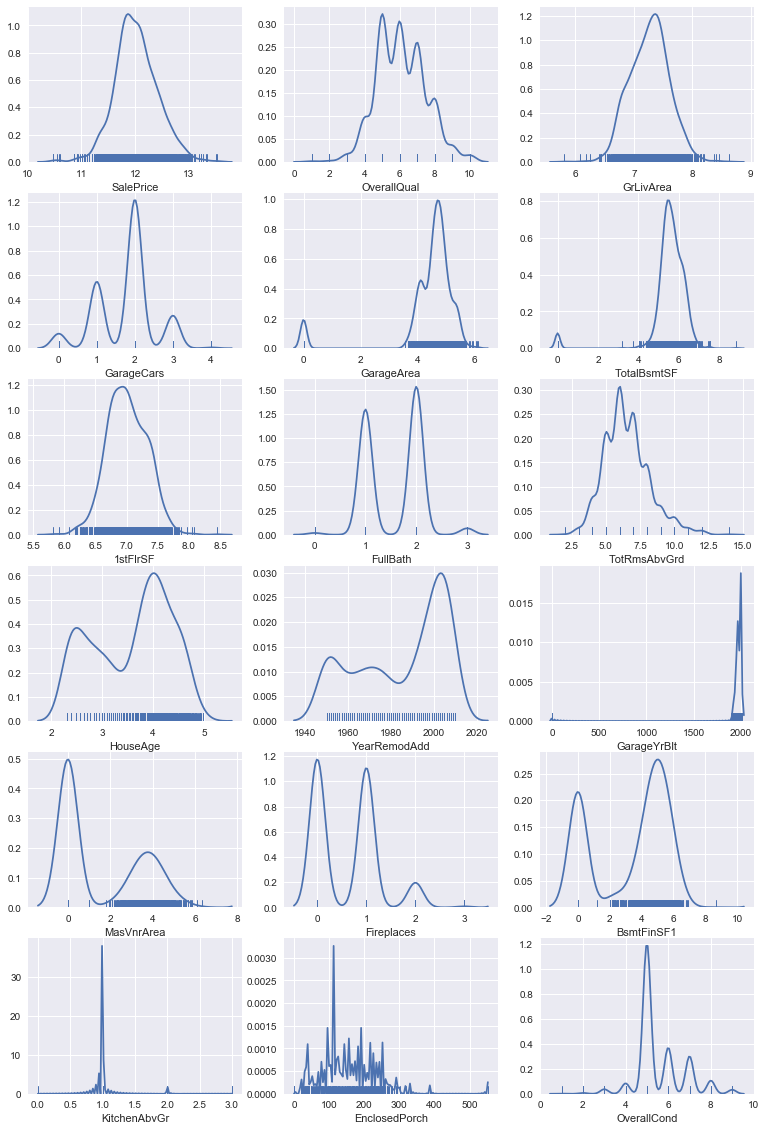

In [10]:
log_trans = ['SalePrice', 'GrLivArea', '1stFlrSF', 'HouseAge']
one_fourth = ['GarageArea', 'TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1']

for col in log_trans:
    if col == 'HouseAge':
        HousesSold[col] = np.log(HousesSold[col] + 10)
    else:
        HousesSold[col] = np.log(HousesSold[col])

for col in one_fourth:
    HousesSold[col] = np.power(HousesSold[col], 0.25)
        
f, axes = plt.subplots(figsize=(13,20), ncols=3, nrows=6)
for i, col in enumerate(['SalePrice']+better_corr_num):
    sb.distplot(HousesSold[HousesSold['data'] == 'train'][[col]], hist=False, rug=True, ax = axes[divmod(i, 3)[0]][i % 3])
    axes[divmod(i, 3)[0]][i % 3].set_xlabel(col)
plt.show()

In [11]:
lr = linear_model.LinearRegression()
lr.fit(HousesSold[HousesSold['data'] == 'train'][better_corr_num]
       , HousesSold[HousesSold['data'] == 'train']['SalePrice'])

rmsle = np.sqrt(mean_squared_error(HousesSold[HousesSold['data'] == 'train']['SalePrice']
                         , lr.predict(HousesSold[HousesSold['data'] == 'train'][better_corr_num])))
print(rmsle)

0.142393382601


In [12]:
y = HousesSold[HousesSold['data'] == 'train']['SalePrice']
cats_list = HousesSold.select_dtypes(exclude=[np.number]).columns.tolist()
master_cats = {}

for j in range(15):
    cats_impr = {}
    for col in cats_list:
        X = pd.get_dummies(HousesSold[HousesSold['data'] == 'train'][better_corr_num + list(master_cats.keys()) + [col]], drop_first = True)
        lr.fit(X, y)
        cats_impr[col] = np.sqrt(mean_squared_error(y, lr.predict(X)))
    best_col = min(cats_impr, key=cats_impr.get)
    master_cats[best_col] = cats_impr[best_col]
    cats_list.remove(best_col)

for key, value in sorted(master_cats.items(), key=lambda item: (item[1], item[0]), reverse = True):
    print ("%s: %s" % (key, value))

Neighborhood: 0.129808358608
RoofMatl: 0.124051406535
MSZoning: 0.120896170538
Functional: 0.118056531083
Condition2: 0.116067829772
MSSubClass: 0.114038917759
Exterior1st: 0.112093170372
Condition1: 0.110414403776
KitchenQual: 0.108861125305
SaleCondition: 0.107801242357
LotConfig: 0.10689414042
Heating: 0.105983496476
SaleType: 0.105317164166
Foundation: 0.104775105047
HeatingQC: 0.10424660862


Let's use the following categorical variables in our model:
1. $Neighborhood$
1. $RoofMatl$
1. $MSZoning$
1. $Functional$
1. $Condition2$
1. $MSSubClass$
1. $Exterior1st$
1. $Condition1$
1. $KitchenQual$
1. $SaleCondition$
1. $LotConfig$
1. $Heating$


Now we use the numerical and categorical variables identified above to build and tune the model.
## Optimum $k$ of cross validation
To find out the optimum folds of K Fold cross validation we execute the following experiment:

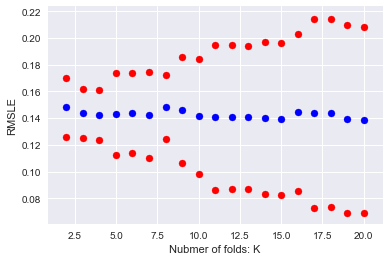

In [13]:
def my_loss_func(xx, yy):
    return np.sqrt(mean_squared_error(xx, yy))

my_scorer = make_scorer(my_loss_func, greater_is_better = False)

better_corr_cat = ['Neighborhood', 'RoofMatl', 'MSZoning', 'Functional', 'Condition2', 'MSSubClass'
                   , 'Exterior1st', 'Condition1', 'KitchenQual', 'SaleCondition', 'LotConfig', 'Heating']
HousesSold = HousesSold[better_corr_num + better_corr_cat + ['data', 'SaleType']]
X = pd.get_dummies(HousesSold[better_corr_num + better_corr_cat + ['data']], drop_first = True
                  , columns = better_corr_cat)
X_train = X[X['data'] == 'train']
X_train = X_train.drop(labels = ['data'], axis = 1)
X_test = X[X['data'] == 'test']
X_test = X_test.drop(labels = ['data'], axis = 1)
k_vals = []
mse_u = []
mse_l = []
mse_m = []
for k in range(2, 21):
    mod_crossval = linear_model.LinearRegression()
    scores = -cross_val_score(mod_crossval
                              , X_train
                              , y
                              , cv=k
                              , scoring = my_scorer)
    k_vals.append(k)
    mse_u.append(scores.mean() + scores.std() * 2)
    mse_l.append(scores.mean() - scores.std() * 2)
    mse_m.append(scores.mean())
    
plt.scatter(k_vals, mse_m, c = 'b')
plt.scatter(k_vals, mse_l, c = 'r')
plt.scatter(k_vals, mse_u, c = 'r')
plt.xlabel('Nubmer of folds: K')
plt.ylabel('RMSLE')
plt.show()


This suggests that a 5 to 10 folds cross validation is good for this data set. Any lower $k$ results in training data sets to of smaller size and for $k>10$, test sets are very small and there is greater dispersion in their scores. We will pick a $k$ value of 10 for this project to tune our models.

## The model
### Elastic Net
We want to try Elastic Net model which is usual GLM but has a loss funtion that is a combination of ordinary least squared error term plus a penalty term. This penalty term is a blend of norm of coefficients of type 1 and 2. We will have to optimize the hyperparameters of the model. There are two hyperparameters that help tune the model.

In [14]:
alpha = np.linspace(0.0001, 0.8, 10)
l1_ratio = np.linspace(0, 1, 10)
hyperparameters = dict(alpha=alpha, l1_ratio=l1_ratio)
eln = linear_model.ElasticNet(max_iter = 10000, tol = 0.001)
cv = RepeatedKFold(n_splits=10, n_repeats=3)
grid_eln = GridSearchCV(eln
                        , hyperparameters
                        , cv=cv
                        , verbose=0
                        , scoring = my_scorer
                        , return_train_score = True)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_eln.fit(X_train, y)

In [15]:
print('Best parameters:', grid_eln.best_estimator_.get_params())
print('Best Score:', -grid_eln.best_score_)

Best parameters: {'alpha': 0.0001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': False}
Best Score: 0.130884868981


This suggests that the optimum value of $\alpha$ (alpha) is very small, or a very small regularization is needed. Let's apply this set of optimum parameters set to fit the final model on the entire data set and use this to predict the house prices of the `test` data set.

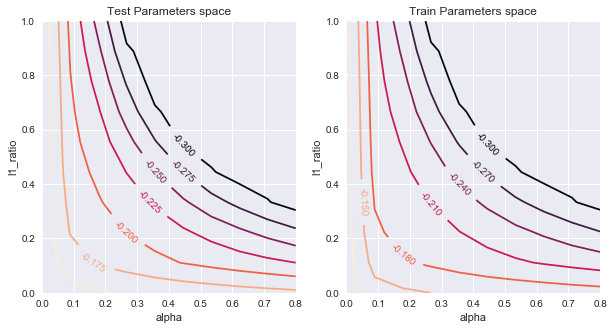

In [16]:
f, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
test_scores = grid_eln.cv_results_['mean_test_score'].reshape(len(alpha), len(l1_ratio))
train_scores = grid_eln.cv_results_['mean_train_score'].reshape(len(alpha), len(l1_ratio))
param_alpha = grid_eln.cv_results_['param_alpha'].reshape(len(alpha), len(l1_ratio))
param_l1_ratio = grid_eln.cv_results_['param_l1_ratio'].reshape(len(alpha), len(l1_ratio))
CS = axes[0].contour(param_alpha, param_l1_ratio, test_scores)
plt.clabel(CS, inline=1, fontsize=10)
axes[0].set_title('Test Parameters space')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('l1_ratio')

CS1 = axes[1].contour(param_alpha, param_l1_ratio, train_scores)
plt.clabel(CS1, inline=1, fontsize=10)
axes[1].set_title('Train Parameters space')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('l1_ratio')
plt.show()

The final Elastic Net model can be built using the hyperparameter values as alpha = 0.0001 and l1_ratio = 1. Thus

In [17]:
eln_final = linear_model.ElasticNet(alpha = 0.0001, l1_ratio = 1.0)
eln_final.fit(X_train, y)
missing_test = X_test.isnull().sum().sort_values(ascending=False)
missing_test[missing_test > 0]

GarageCars     1
GarageArea     1
TotalBsmtSF    1
BsmtFinSF1     1
dtype: int64

In [18]:
X_test['GarageCars'].fillna(0, inplace = True)
X_test['BsmtFinSF1'].fillna(0, inplace = True)
X_test['GarageArea'].fillna(0, inplace = True)
X_test['TotalBsmtSF'].fillna(0, inplace = True)

X_test['SalePrice'] = np.exp(eln_final.predict(X_test))
prediction_eln = X_test[['SalePrice']]
prediction_eln.to_csv('data/prediction_eln.csv', sep=',')

### Linear Regression
It is also worth fitting a Linear Regression model as the optimum regularization is very small in the Elastic Net model.

In [19]:
X_test.drop(labels=['SalePrice'], axis = 1, inplace = True)
lr = linear_model.LinearRegression()
lr.fit(X_train, y)
X_test['SalePrice'] = np.exp(lr.predict(X_test))
prediction_lr = X_test[['SalePrice']]
prediction_lr.to_csv('data/prediction_lr.csv', sep=',')

### Random Forest
Let us fit and tune a randome forest model on this data and see how that performs on the cross folds. There are a few hyperparameters involved in this model that we would like to tune:
1. `n_estimators`
1. `max_depth`
1. `min_samples_split`
1. `min_samples_leaf`
1. `max_features`
1. `bootstrap`

#### `n_estimators`
This is the first hyperparameter that we would like to tune for the random forest model. We will try a sequence of this hyperparameter and observe the performance of the models built with each of these values of the `n_estimators` on the test sets as chosen in the cross validation splits above.

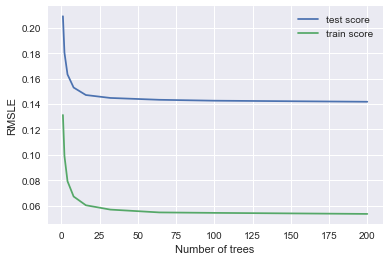

In [20]:
rf = RandomForestRegressor(n_jobs = -1)
estimators_grid = {"n_estimators" : [1, 2, 4, 8, 16, 32, 64, 100, 200] # number of trees in rf
              }
rf_estimators = GridSearchCV(estimator = rf
                             , cv = cv
                             , param_grid = estimators_grid
                             , verbose = 0
                             , scoring = my_scorer
                             , return_train_score = True)
rf_estimators.fit(X_train, y)

plt.plot(estimators_grid['n_estimators'], -rf_estimators.cv_results_['mean_test_score'], label='test score')
plt.plot(estimators_grid['n_estimators'], -rf_estimators.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('RMSLE')
plt.show()

It is evident from these results that the learning curve becomes almost flat after `n_estimators` = 75.
#### `max_depth`
 We will now experiment to pick the best `max_depth` parameter.

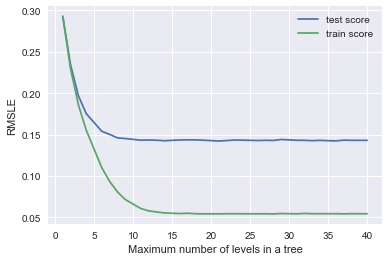

In [21]:
depths_grid = {"n_estimators" : [75] # number of trees in rf
               , "max_depth" : [int(x) for x in np.linspace(start = 1, stop = 40
                                                            , num = 32, endpoint = True)] # max num of levels in a tree
              }
rf_depths = GridSearchCV(estimator = rf
                         , cv = cv
                         , param_grid = depths_grid
                         , verbose = 0
                         , scoring = my_scorer
                         , return_train_score = True)
rf_depths.fit(X_train, y)

plt.plot(depths_grid['max_depth'], -rf_depths.cv_results_['mean_test_score'], label='test score')
plt.plot(depths_grid['max_depth'], -rf_depths.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Maximum number of levels in a tree')
plt.ylabel('RMSLE')
plt.show()

We will pick `max_depth` = 15 because after that the learning curve of the test set is almost flat.
#### `min_samples_split`
This is the next hyperparameter we would like to tune.

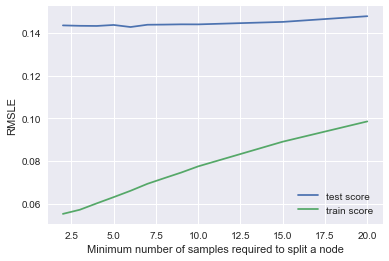

In [22]:
samples_split_grid = {"n_estimators" : [75] # number of trees in rf
               , "max_depth" : [15] # max num of levels in a tree
               , "min_samples_split" : [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20] # min num of samples required to split a node
              }
rf_samples_split = GridSearchCV(estimator = rf
                                , cv = cv
                                , param_grid = samples_split_grid
                                , verbose = 0
                                , scoring = my_scorer
                                , return_train_score = True)
rf_samples_split.fit(X_train, y)

plt.plot(samples_split_grid['min_samples_split'], -rf_samples_split.cv_results_['mean_test_score'], label='test score')
plt.plot(samples_split_grid['min_samples_split'], -rf_samples_split.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Minimum number of samples required to split a node')
plt.ylabel('RMSLE')
plt.show()

The optimum `min_samples_split` seems to be the 3.
#### `min_samples_leaf`
Now let's experiment with the `min_samples_leaf` hyperparameter.

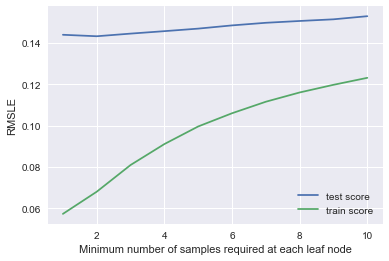

In [23]:
samples_leaf_grid = {"n_estimators" : [75] # number of trees in rf
               , "max_depth" : [15] # max num of levels in a tree
               , "min_samples_split" : [3] # min num of samples required to split a node
               , "min_samples_leaf" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # min num of samples req at each leaf node
              }
rf_samples_leaf = GridSearchCV(estimator = rf
                               , cv = cv
                               , param_grid = samples_leaf_grid
                               , verbose = 0
                               , scoring = my_scorer
                               , return_train_score = True)
rf_samples_leaf.fit(X_train, y)

plt.plot(samples_leaf_grid['min_samples_leaf'], -rf_samples_leaf.cv_results_['mean_test_score'], label='test score')
plt.plot(samples_leaf_grid['min_samples_leaf'], -rf_samples_leaf.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Minimum number of samples required at each leaf node')
plt.ylabel('RMSLE')
plt.show()

I will choose `min_samples_leaf = 1` for this project.
#### `max_features`
Now it is the turn for `max_features` parameter. Let's experiment that.

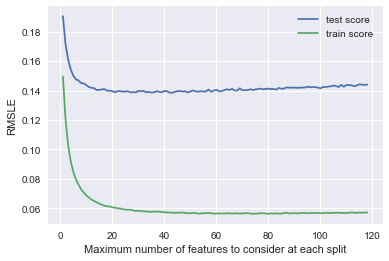

In [24]:
features_grid = {"n_estimators" : [75] # number of trees in rf
                 , "max_depth" : [15] # max num of levels in a tree
                 , "min_samples_split" : [3] # min num of samples required to split a node
                 , "min_samples_leaf" : [1] # min num of samples req at each leaf node
                 , "max_features" : list(range(1, X_train.shape[1])) # number of features to consider at every split
                }
rf_features = GridSearchCV(estimator = rf
                           , cv = cv
                           , param_grid = features_grid
                           , verbose = 0
                           , scoring = my_scorer
                           , return_train_score = True)
rf_features.fit(X_train, y)

plt.plot(features_grid['max_features'], -rf_features.cv_results_['mean_test_score'], label='test score')
plt.plot(features_grid['max_features'], -rf_features.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Maximum number of features to consider at each split')
plt.ylabel('RMSLE')
plt.show()

It seems like the best value of the `max_features` is around 40.
#### `bootstrap`
Finally let us experiment the `bootstrap` method.

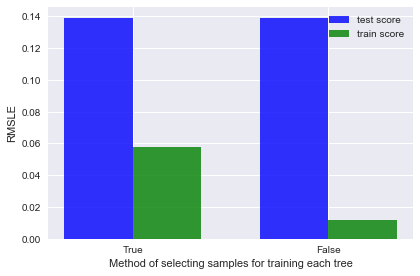

In [25]:
bootstrap_grid = {"n_estimators" : [75] # number of trees in rf
                  , "max_depth" : [15] # max num of levels in a tree
                  , "min_samples_split" : [3] # min num of samples required to split a node
                  , "min_samples_leaf" : [1] # min num of samples req at each leaf node
                  , "max_features" : [40] # number of features to consider at every split
                  , "bootstrap" : [True, False] # method of selecting samples for training each tree
                 }
rf_bootstrap = GridSearchCV(estimator = rf
                            , cv = cv
                            , param_grid = bootstrap_grid
                            , verbose = 0
                            , scoring = my_scorer
                            , return_train_score = True)
rf_bootstrap.fit(X_train, y)

fig, ax = plt.subplots()
rects1 = plt.bar(np.array([0, 1]), -rf_bootstrap.cv_results_['mean_test_score'], width = 0.35,
                 alpha = 0.8,
                 color = 'b',
                 label = 'test score')
 
rects2 = plt.bar(np.array([0, 1]) + 0.35, -rf_bootstrap.cv_results_['mean_train_score'], width = 0.35,
                 alpha = 0.8,
                 color = 'g',
                 label = 'train score')
 
plt.xlabel('Method of selecting samples for training each tree')
plt.ylabel('RMSLE')
plt.xticks(np.array([0, 1]) + 0.35/2, ('True', 'False'))
plt.legend()
 
plt.tight_layout()
plt.show()

The `bootstrap = False` seems to have performed slightly better on the test sets. Now we are good to fit the final random forest model with the 'tuned hyperparameters'.

In [26]:
rf_final = RandomForestRegressor(n_estimators = 75
                                 , max_depth = 15
                                 , min_samples_split = 3
                                 , min_samples_leaf = 1
                                 , max_features = 40
                                 , bootstrap = False)
rf_final.fit(X_train, y)

X_test.drop(labels=['SalePrice'], axis = 1, inplace = True)
X_test['SalePrice'] = np.exp(rf_final.predict(X_test))
prediction_rf = X_test[['SalePrice']]
prediction_rf.to_csv('data/prediction_rf.csv', sep=',')

### XGBoost
Let's use another model out of the set of ensemble models; the extreme gradient boost. This ensemble model falls in the boosting ensemble technique whereas the random forest falls in the bagging ensemble technique. The individual estimators or the predictors that are ensembled in the extreme gradient boost model can either be the `gbtree` or the `gblinear`. We will use `gbtree` booster estimators while using `reg:linear` objective function i.e., a loss function will be minimized. In case of `gbtree` estimators, there are the following hyperparameters that will need to be tuned:
1. `n_estimators` (the number of individual predictors or estimators ensembled sequentially)
1. `learning_rate` (this is weighting on the corrections made by the new estimators when added to the model)
1. `max_depth` (the maximum depth each tree can grow)
1. `gamma` (it is the pseudo-regularization hyperparameter or Lagrangian multiplier, the higher values of gamma means more regularization)
1. `colsample_bytree` (the randomly chosen fraction of columns used in each estimator)
1. `min_child_weight` (Minimum sum of instance weight (hessian) needed in a child. The larger the `min_child_weight`, the more conservative the resultant model will be)
1. `subsample` (the randomly chosen fraction of the observations in each estimator)

#### 1. Number of iterations and the learning rate
We will tune the bigger knobs first. As the maximum tree depth is also depending on the number of iterations and the learning rate, we want to experiment with it at this point to narrow down the search for possible hyperparameters.

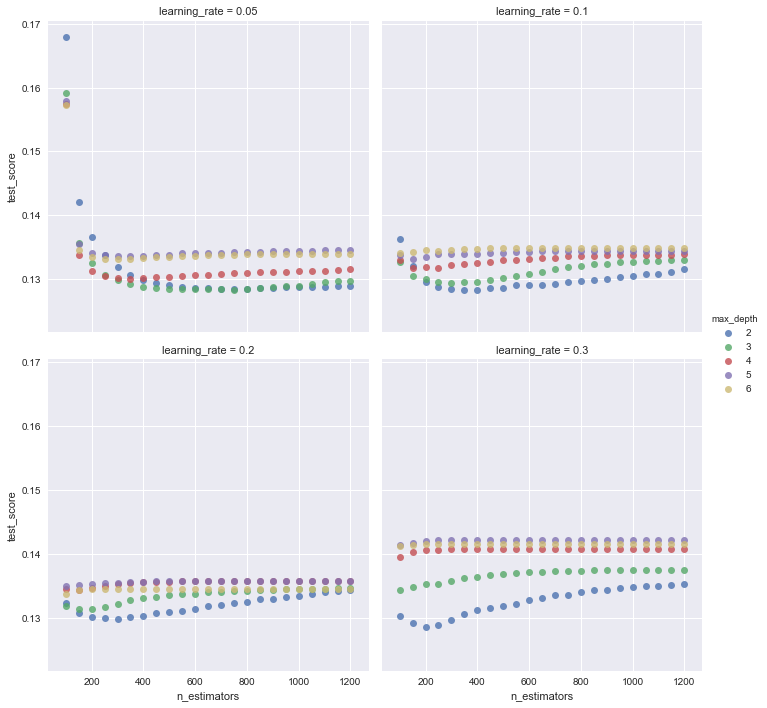

In [27]:
xgb_basic = XGBRegressor(objective = 'reg:linear'
                        , booster = 'gbtree'
                        , n_jobs = -1)

xgb_grid1 = {"n_estimators" : range(100, 1250, 50)
             , "learning_rate" : [0.05, 0.1, 0.2, 0.3]
             , "max_depth" : [2, 3, 4, 5, 6]
             , "gamma" : [0]
             , "colsample_bytree" : [1]
             , "min_child_weight" : [1]
             , "subsample" : [1]
            }

xgb_gridsearch1 = GridSearchCV(estimator = xgb_basic
                               , param_grid = xgb_grid1
                               , verbose = 0
                               , scoring = my_scorer
                               , return_train_score = True)
xgb_gridsearch1.fit(X_train, y)

xgb_gridsearch1_results = pd.DataFrame(xgb_gridsearch1.cv_results_['params'])
xgb_gridsearch1_results['train_score'] = -xgb_gridsearch1.cv_results_['mean_train_score']
xgb_gridsearch1_results['test_score'] = -xgb_gridsearch1.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch1_results
          , hue = 'max_depth'
          , col = 'learning_rate'
          , fit_reg = False
          , col_wrap = 2
         )

plt.show()

The plots above suggest that the best learning rates is 0.05 and the maximum depth is 3.

#### 2. Maximum depth and minimum child weight

We will fix the learning rate at 0.05 and and will vary the maximum depth at $3 \pm 1$. We will try to find the best set of minimum child weight and maximum depth.

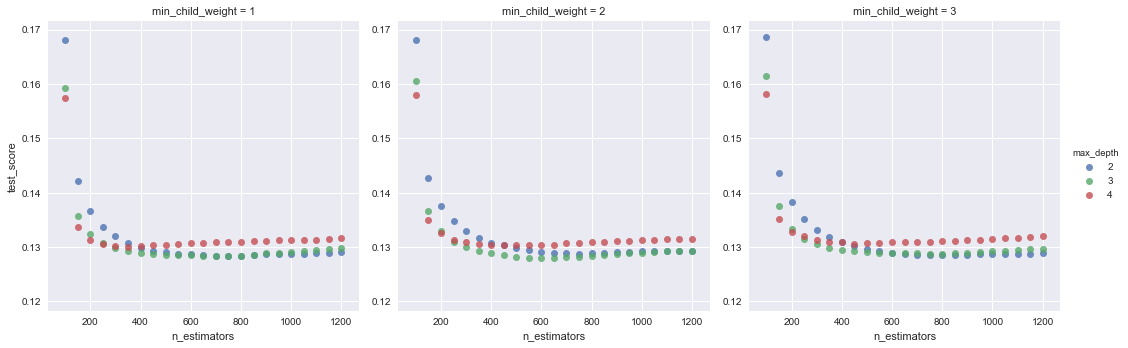

In [28]:
xgb_grid2 = {"n_estimators" : range(100, 1250, 50)
             , "learning_rate" : [0.05]
             , "max_depth" : [2, 3, 4]
             , "gamma" : [0]
             , "colsample_bytree" : [1]
             , "min_child_weight" : [1, 2, 3]
             , "subsample" : [1]
            }

xgb_gridsearch2 = GridSearchCV(estimator = xgb_basic
                               , param_grid = xgb_grid2
                               , verbose = 0
                               , scoring = my_scorer
                               , return_train_score = True)
xgb_gridsearch2.fit(X_train, y)

xgb_gridsearch2_results = pd.DataFrame(xgb_gridsearch2.cv_results_['params'])
xgb_gridsearch2_results['train_score'] = -xgb_gridsearch2.cv_results_['mean_train_score']
xgb_gridsearch2_results['test_score'] = -xgb_gridsearch2.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch2_results
          , hue = 'max_depth'
          , col = 'min_child_weight'
          , fit_reg = False
         )

plt.show()

The plots suggest that the best maximum depth is 3 and the best minimum child weight is 2.

#### 3. Column and row sampling
After fixing the maximum depth and minimum child weight we will experiment different values of column and row sampling fractions in each booster iteration.

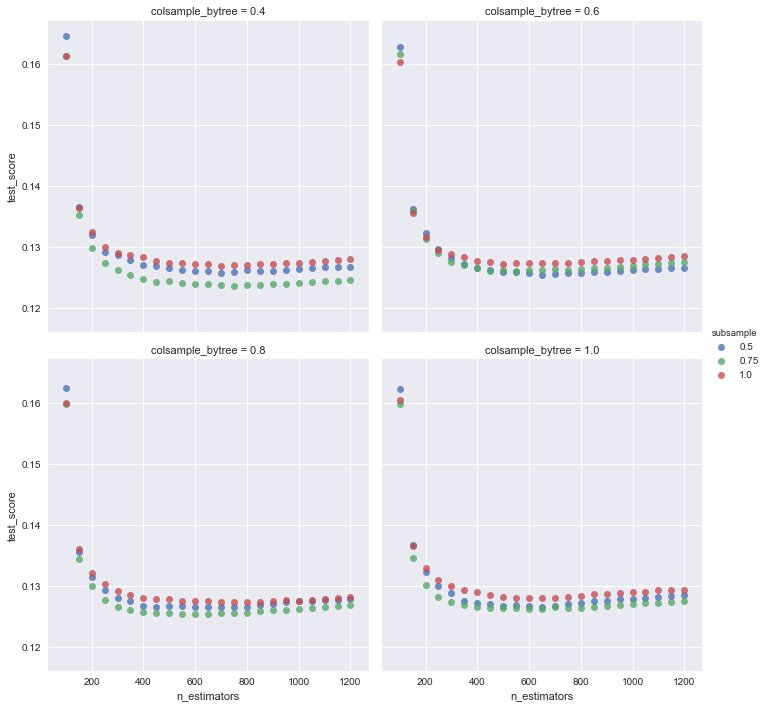

In [29]:
xgb_grid3 = {"n_estimators" : range(100, 1250, 50)
             , "learning_rate" : [0.05]
             , "max_depth" : [3]
             , "gamma" : [0]
             , "colsample_bytree" : [.4, .6, .8, 1]
             , "min_child_weight" : [2]
             , "subsample" : [0.5, 0.75, 1.0]
            }

xgb_gridsearch3 = GridSearchCV(estimator = xgb_basic
                               , param_grid = xgb_grid3
                               , verbose = 0
                               , scoring = my_scorer
                               , return_train_score = True)
xgb_gridsearch3.fit(X_train, y)

xgb_gridsearch3_results = pd.DataFrame(xgb_gridsearch3.cv_results_['params'])
xgb_gridsearch3_results['train_score'] = -xgb_gridsearch3.cv_results_['mean_train_score']
xgb_gridsearch3_results['test_score'] = -xgb_gridsearch3.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch3_results
          , hue = 'subsample'
          , col = 'colsample_bytree'
          , fit_reg = False
          , col_wrap = 2
         )

plt.show()

These results suggest that the best values of column sampling is 0.4 and that of row sampling is 0.75.

#### 4. Gamma
Lets try finding the best value of gamma.

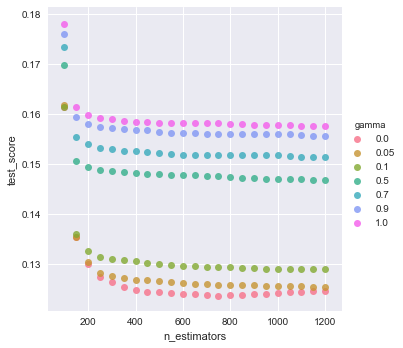

In [30]:
xgb_grid4 = {"n_estimators" : range(100, 1250, 50)
             , "learning_rate" : [0.05]
             , "max_depth" : [3]
             , "gamma" : [0, 0.05, 0.1, 0.5, 0.7, 0.9, 1.0]
             , "colsample_bytree" : [.4]
             , "min_child_weight" : [2]
             , "subsample" : [0.75]
            }

xgb_gridsearch4 = GridSearchCV(estimator = xgb_basic
                               , param_grid = xgb_grid4
                               , verbose = 0
                               , scoring = my_scorer
                               , return_train_score = True)
xgb_gridsearch4.fit(X_train, y)

xgb_gridsearch4_results = pd.DataFrame(xgb_gridsearch4.cv_results_['params'])
xgb_gridsearch4_results['train_score'] = -xgb_gridsearch4.cv_results_['mean_train_score']
xgb_gridsearch4_results['test_score'] = -xgb_gridsearch4.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch4_results
          , hue = 'gamma'
          , fit_reg = False
         )

plt.show()

The best value of the hyperparameter gamma is 0.

#### 5. Reducing the learning rate
After tuning the hyperparameters we will reduce the learning rate to get the best trade off between the bias and variance.

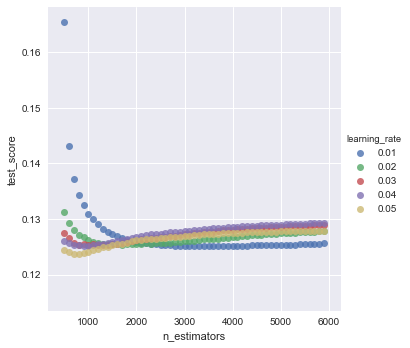

In [31]:
xgb_grid5 = {"n_estimators" : range(500, 6000, 100)
             , "learning_rate" : [0.01, 0.02, 0.03, 0.04, 0.05]
             , "max_depth" : [3]
             , "gamma" : [0]
             , "colsample_bytree" : [.4]
             , "min_child_weight" : [2]
             , "subsample" : [0.75]
            }

xgb_gridsearch5 = GridSearchCV(estimator = xgb_basic
                               , param_grid = xgb_grid5
                               , verbose = 0
                               , scoring = my_scorer
                               , return_train_score = True)
xgb_gridsearch5.fit(X_train, y)

xgb_gridsearch5_results = pd.DataFrame(xgb_gridsearch5.cv_results_['params'])
xgb_gridsearch5_results['train_score'] = -xgb_gridsearch5.cv_results_['mean_train_score']
xgb_gridsearch5_results['test_score'] = -xgb_gridsearch5.cv_results_['mean_test_score']

sb.lmplot(x = 'n_estimators'
          , y = 'test_score'
          , data = xgb_gridsearch5_results
          , hue = 'learning_rate'
          , fit_reg = False
         )

plt.show()

The RMSLE score on the test validation sets and on the training sets is plotted in the figure below.

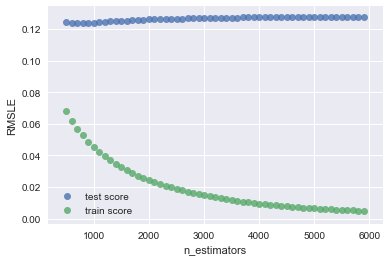

In [32]:
sb.regplot(x = 'n_estimators', y='test_score'
           , data = xgb_gridsearch5_results[xgb_gridsearch5_results['learning_rate'] == 0.05]
           , fit_reg = False
           , label = 'test score')
sb.regplot(x = 'n_estimators', y='train_score'
           , data = xgb_gridsearch5_results[xgb_gridsearch5_results['learning_rate'] == 0.05]
           , fit_reg = False
           , label = 'train score')
plt.ylabel('RMSLE')
plt.legend()
plt.show()

The best number of estimators that result in the minimum test score is 750.

#### Final Model
Lets train the final model on the entire training set with the tuned set of hyperparameters and produce a submission file.

In [33]:
final_xgb = XGBRegressor(objective = 'reg:linear'
                         , booster = 'gbtree'
                         , n_jobs = -1
                         , n_estimators = 750
                         , learning_rate = 0.05
                         , max_depth = 3
                         , gamma = 0
                         , colsample_bytree = .4
                         , min_child_weight = 2
                         , subsample = 0.75
                        )
final_xgb.fit(X_train, y)
X_test.drop(labels=['SalePrice'], axis = 1, inplace = True)
X_test['SalePrice'] = np.exp(final_xgb.predict(X_test))
prediction_xgb = X_test[['SalePrice']]
prediction_xgb.to_csv('data/prediction_xgb.csv', sep=',')

As the score on the test sets was suggesting, this model produced the best score on the Kaggle leader board among the rest of the models trained above.